# Tutorial: Processing Eye-Tracking Data with PyNeon

## Step 1: Loading Sample Data

First, we'll load sample eye-tracking data provided by PyNeon. In particular, we will download the 

In [1]:
import numpy as np
from pyneon import NeonRecording, get_sample_data
from pyneon.preprocess import *
import pathlib as path

get_sample_data('CircleFlash')
# Load the sample recording
recording_dir = path.Path(r"C:\Users\jan-gabriel.hartel\Documents\GitHub\PyNeon\data\Timeseries Data + Scene Video\circleflash-e38cc9a4")
#check if the dir exists
recording = NeonRecording(recording_dir)

In [2]:
import pyneon.epochs
from pyneon.epochs import events_to_times_df

# convert the events to a times dataframe
times_df = events_to_times_df(recording.events, t_before=0.2, t_after=0.5, t_unit='s')

# check the times_df
print(times_df.head())

#drop the first and last row
times_df = times_df.iloc[1:-1]

                 t_ref     t_before      t_after description
0  1737731728162000000  200000000.0  500000000.0       event
1  1737731733721022000  200000000.0  500000000.0       event
2  1737731735801775000  200000000.0  500000000.0       event
3  1737731737910627000  200000000.0  500000000.0       event
4  1737731740103648000  200000000.0  500000000.0       event


In [3]:
#Creaate an Epoch with the times_df
epoch = pyneon.Epochs(recording.eye_states, times_df)

In [4]:
print(epoch.data.columns)

Index(['pupil diameter left [mm]', 'pupil diameter right [mm]',
       'eyeball center left x [mm]', 'eyeball center left y [mm]',
       'eyeball center left z [mm]', 'eyeball center right x [mm]',
       'eyeball center right y [mm]', 'eyeball center right z [mm]',
       'optical axis left x', 'optical axis left y', 'optical axis left z',
       'optical axis right x', 'optical axis right y', 'optical axis right z',
       'epoch index', 'epoch time', 'epoch description'],
      dtype='object')


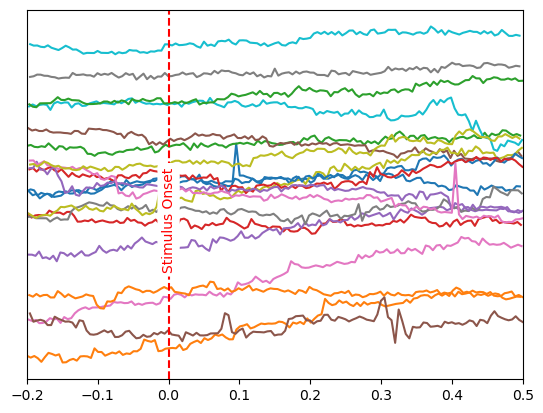

In [30]:
import matplotlib.pyplot as plt
# for each unique epoch index

for i in epoch.data['epoch index'].unique():
    times = epoch.data[epoch.data['epoch index'] == i]['epoch time'].values/1e9
    pupil = epoch.data[epoch.data['epoch index'] == i]['pupil diameter left [mm]'].values +i/10

    #plot the times and pupil diameter
    plt.plot(times, pupil)

# hide the y-axis labels
plt.yticks([])
plt.xlim(-0.2, 0.5)
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0, 4., 'Stimulus Onset', color='r', ha='center', rotation=90, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))
plt.show()


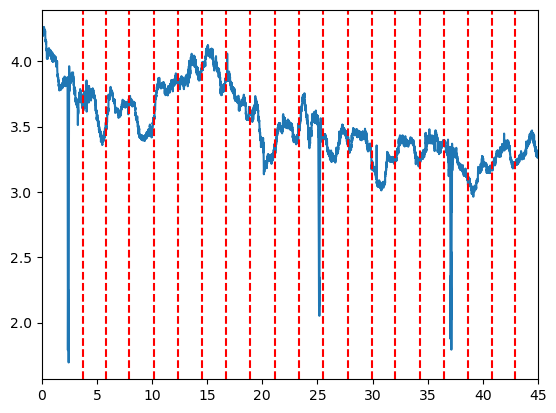

In [37]:
#plot the unepoched data
times = (recording.eye_states.data.index- min(recording.eye_states.data.index))/1e9
# extract the events
event_times = recording.events.data.loc[recording.events.data['name'] == 'Gabor onset'].index.values
event_times = (event_times - min(recording.eye_states.data.index))/1e9
plt.plot(times, recording.eye_states['pupil diameter left [mm]'].values)
plt.xlim(0, 45)
#draw a red vertical line at the event times
for event_time in event_times:
    plt.axvline(x=event_time, color='r', linestyle='--')


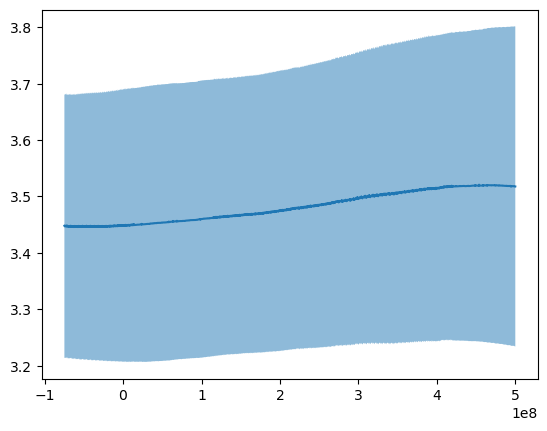

In [6]:
#sort by epoch time
epoch.data = epoch.data.sort_values(by=['epoch time'])
#average in a window of 0.01 seconds
pupil_mean = epoch.data['pupil diameter left [mm]'].rolling(window=500).mean()
#compite standard deviation
pupil_std = epoch.data['pupil diameter left [mm]'].rolling(window=500).std()
#plot the mean pupil diameter and standard deviation
plt.plot(epoch.data['epoch time'], pupil_mean, label='mean')
plt.fill_between(epoch.data['epoch time'], pupil_mean - pupil_std, pupil_mean + pupil_std, alpha=0.5, label='std')

In [7]:
epochs_np = epoch.to_numpy()

ValueError: The source must be a uniformly-sampled NeonStream to convert to NumPy array.

In [8]:
epochs_interp = pyneon.Epochs(recording.eye_states.interpolate(), times_df)
epochs_interp_np, info = epochs_interp.to_numpy()

Text(0, 0.5, 'Pupil Diameter [mm]')

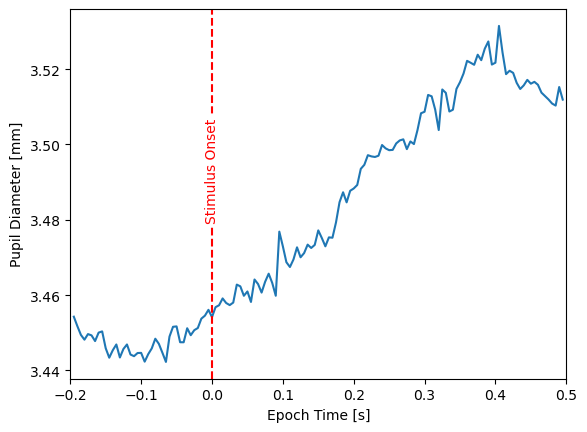

In [17]:
# average across all epochs
pupil_mean = epochs_interp_np[:, 0, :].mean(axis=0)
# compute standard deviation
pupil_std = epochs_interp_np[:, 0, :].std(axis=0)
# plot the mean pupil diameter and standard deviation
plt.plot(info['epoch_times'], pupil_mean, label='mean')
plt.xlim(-0.2, 0.5)
#show a vertical line at 0
plt.axvline(x=0, color='r', linestyle='--')
plt.text(0, 3.48, 'Stimulus Onset', color='r', ha='center', rotation=90, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))
#add x and y labels
plt.xlabel('Epoch Time [s]')
plt.ylabel('Pupil Diameter [mm]')